In [1]:
from sklearn.decomposition import PCA
import data_prep as dp
import matplotlib.pyplot as plt
import statistics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
import datetime as dt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import scipy
import pickle
import matplotlib.dates as mdates









pd.set_option('display.max_columns', 1500) 
pd.set_option('display.max_rows', 1500) 

In [2]:
!pip install openpyxl

In [11]:
def itr(ac):
    num_tac= 6 #possible selections
    spm = 60000/620/8/num_tac #selections per minute
    itr = (np.log2(num_tac)+ ac*np.log2(ac)+ (1-ac)* np.log2((1-ac)/(num_tac-1)))*spm 
    return itr




def boxplot_accuracy(data,name:str,fname:str): #fnme = formatted name
    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["Accuracy"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    df_list = []
    for classifier in sorted_classifiers[:,1]:
        df = data.loc[(data.Classifier == classifier)& (data.Ep2Avg == 8)]
        df_list.append(df.Accuracy*100)
    fig,ax = plt.subplots(figsize=(12,5))
    ax.boxplot(df_list,labels= sorted_classifiers[:,1],widths=0.3)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=15,ha='right')
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(-15,110)
    ax.axhline(y=-5,c='k', lw=0.5)
    ax.axvspan(int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)-0.25,int(np.where(sorted_classifiers[:,1]=="SWLDA")[0]+1)+0.25, facecolor="#808080", alpha=0.3)
    for i,mean in enumerate(sorted_classifiers[:,0]):
        ax.text(x=i+0.9,y=-11,s=str(round(float(mean)*100)))
    ax.text(x=-0.30,y=-11,s="Ø in %")
    #fig.suptitle(fname)
    plt.savefig(r"created_data\Graphics\Acc_"+name+".svg",format='svg',bbox_inches="tight",pad_inches=0.2)

def bar_itr(data,name:str):
    fig,ax = plt.subplots(figsize=(16,5))

    means = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean()["ITR"].to_list()
    names = data.loc[(data.Ep2Avg==8)].groupby("Classifier").mean().index.to_list()
    sorted_classifiers = np.array(sorted( zip(means, names)))
    values = [float(i) for i in sorted_classifiers[:,0]]
    df_list = []

    ax.bar(sorted_classifiers[:,1],values,width =0.25)
    ax.set_xticklabels(sorted_classifiers[:,1],rotation=30,ha='right')
    ax.set_ylabel("ITR (Bits/Minuite)")
    fig.suptitle("ITR " + name)
    plt.savefig(r"D:\Google Drive\Master\Masterarbeit\Graphics\ITR_boxplot_"+name+".svg",fromat="svg",bbox_inches="tight",pad_inches=0.2)

    
def plot_timeline_without_accuracy(tar_df, ntar_df,electrode,title):
    col_list= ["#377eb8","#e41a1c","#4daf4a","#702963"]
    lr = LinearRegression()

    x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,5))
    y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    y.reshape(-1,1)
    lr.fit(x,y)
    pred = lr.predict(x)
    ##ax.text(3, 8, 'R² = '+ str(round(lr.score(x,y),3), style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    print(lr.score(x,y))
    ax.axvline(x=tar_df.index.values[12],alpha=0.65,zorder=0,c=col_list[2],ls="--",lw=1) # electrode set b    
    ax.axvline(x=tar_df.index.values[21],alpha=0.65,zorder=0,c=col_list[3], ls="--",lw=1)
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1],alpha=0.65)
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0],alpha=0.65)
    trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=1.5,alpha=0.65)
    lgd =ax.legend(["Electrode SetB","Tactor Relocation","Difference Trend ()", "Target", "NonTarget"], ncol=5, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("µV")
    #specify x ticks
    #ax.set_xticks(pd.DatetimeIndex(["10.11.2020","1.12.2020","1.1.2021"],dayfirst=True))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))#("%d.%m.%Y"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
    ax.set_xlabel("Dates")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"created_data\Graphics\Timeline.svg",bbox_inches="tight",pad_inches=0.2,format="svg")    
    
    

def Per2Ac(x):
    return x*25

def Ac2Per(x):
    return x/25


def plot_timeline(tar_df, ntar_df,oa_df,electrode,title):
    col_list= ["#377eb8","#e41a1c","#4daf4a","#702963","k"]
    lr = LinearRegression()

    x = tar_df.index.map(dt.datetime.toordinal).to_numpy()
    x = x.reshape(-1,1)

    fig, ax = plt.subplots(figsize = (12,6))
    y = tar_df["Mean Amplitude"].to_numpy()-ntar_df["Mean Amplitude"].to_numpy()
    y.reshape(-1,1)
    lr.fit(x,y)
    pred = lr.predict(x)
    ##ax.text(3, 8, 'R² = '+ str(round(lr.score(x,y),3), style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    print("R² of the linear regression: {}".format(lr.score(x,y)))
    

    ax.axvline(x=tar_df.index.values[12],alpha=0.65,zorder=0,c=col_list[2],ls="--",lw=1, label= "Electrode SetB") # electrode set b    
    ax.axvline(x=tar_df.index.values[21],alpha=0.65,zorder=0,c=col_list[3], ls="--",lw=1,label = "Tactor Relocation")
    tar = ax.bar(tar_df.index,tar_df["Mean Amplitude"], width=1,color=col_list[1],alpha=0.65, label="Target")
    ntar = ax.bar(tar_df.index,ntar_df["Mean Amplitude"], width=1,color=col_list[0],alpha=0.65, label = "NonTarget")
    trend = ax.plot(tar_df.index,pred,c="k",ls=":",lw=1.5,alpha=0.65, label = "Difference Trend")
    oa = ax.plot(oa_df.index, oa_df,color=col_list[4],lw=0.7, label = "Online Accuracy")
    lgd =ax.legend( ncol=6, title=title,loc='center', bbox_to_anchor=(0.5, 1.13),fontsize='small', fancybox=True)
    ax.axhline(y=0,c='k',lw=0.5)
    ax.set_ylabel("Amplitude [µV]")
    #specify x ticks
    #ax.set_xticks(pd.DatetimeIndex(["10.11.2020","1.12.2020","1.1.2021"],dayfirst=True))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))#("%d.%m.%Y"))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
    sec_ax = ax.secondary_yaxis("right",functions= (Per2Ac,Ac2Per))
    sec_ax.set_ylabel("Accuracy [%]")
    ax.set_xlabel("Dates")
    #fig.suptitle(title)
    fig.tight_layout
    plt.savefig(r"created_data\Graphics\Timeline.svg",bbox_inches="tight",pad_inches=0.2,format="svg")

# Load Data for the first time: Amplitudes + Classifiers

## relabel data: 
add dates to amplitudes
single calibration data was split into two sets of electrodes, comnbine them

In [4]:
def load_session_dates():
    with open(r"C:\Users\map92fg\Documents\Software\P300_Classification\data_thesis\date_dict.pickle", "rb") as file:
        SESS_DATES = pickle.load(file)
    return SESS_DATES

SESS_DATES = load_session_dates()
amp = pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\average_amplitudes_350_600.csv")
amp["Dates"] = amp["Session"].replace(SESS_DATES)

amp.to_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\created_data\average_amplitudes_350_600_with_dates.csv",index=False)


all_acc =  pd.read_csv(r"created_data\Classifier_Results\current\accuracies.csv")
all_acc["Condition"] = all_acc["Condition"].map({"sess3":"sess3","sess1":"sess1","single3_A":"single3","single3_B":"single3","single1_A":"single1","single1_B":"single1"}, na_action='ignore')
#change NaN values in SWLDA (those sessions in which the SWLDA was unable to form a classifier)
all_acc.Accuracy = all_acc.Accuracy.fillna(value=0)
all_acc.to_csv(r"created_data\Classifier_Results\current\accuracies_rightlabel.csv",index=False)
all_acc["Condition"].isnull().any().sum()

#create a df with all the averages and stds
overview = pd.DataFrame()
overview["sess3_ac"] = np.round(sess3.groupby("Classifier").mean()["Accuracy"]
overview["sess3_std"] = sess3.groupby("Classifier").std()["Accuracy"]
overview["sess1_ac"] = sess1.groupby("Classifier").mean()["Accuracy"]
overview["sess1_std"] = sess1.groupby("Classifier").std()["Accuracy"]
overview["single3_ac"] = single3.groupby("Classifier").mean()["Accuracy"]
overview["single3_std"] = single3.groupby("Classifier").std()["Accuracy"]
overview["single1_ac"] = single1.groupby("Classifier").mean()["Accuracy"]
overview["single1_std"] = single1.groupby("Classifier").std()["Accuracy"]
overview.to_csv(r"created_data\Classifier_Results\current\accuracies_overview.csv")

SyntaxError: invalid syntax (4175665461.py, line 23)

# Online Data - Amplitudes + Accuracy
### Load Online Accuracy

In [5]:
oa = pd.read_csv(r"C:\Users\map92fg\Documents\Software\P300_Classification\data_thesis\online_accuracy.csv", sep=";")
oa = oa.set_index(pd.to_datetime(oa.Datum,format="%d.%m.%Y"),drop=True)
oa["Online Accuracy"] = oa["Online Accuracy"].str.rstrip('%').astype('float') / 100.0
oa = oa["Online Accuracy"]*4 # to map on the primary y-axis

### Load Amplitudes

In [6]:
amp = pd.read_csv(r"created_data\average_amplitudes_350_600_with_dates.csv")
t = amp.loc[(amp.Condition=="Target")&(amp.Electrode=="Cz")]
nt= amp.loc[(amp.Condition=="nonTarget")&(amp.Electrode=="Cz")]

In [7]:
t_mean = t.groupby('Dates').mean()
t_mean = t_mean.set_index(pd.to_datetime(t_mean.index,dayfirst=True),drop=True)
t_mean = t_mean.sort_index()
nt_mean = nt.groupby('Dates').mean()
nt_mean = nt_mean.set_index(pd.to_datetime(nt_mean.index,dayfirst=True),drop=True)
nt_mean = nt_mean.sort_index()

### Plot Timeline

R² of the linear regression: 0.17301501415860188


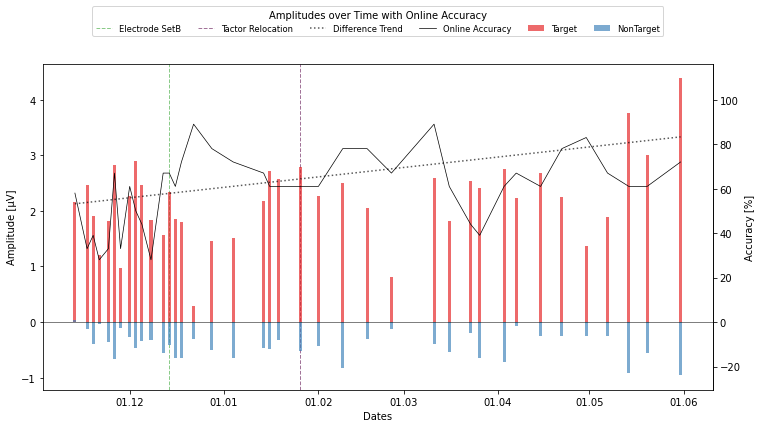

In [10]:
plot_timeline(t_mean,nt_mean,oa,"Cz","Amplitudes over Time with Online Accuracy")

# Offline Analysis: Classifiers
### Load classification results

In [12]:
all_acc = pd.read_csv(r"created_data\Classifier_Results\current\accuracies_rightlabel.csv")

In [13]:
#change NaN values in SWLDA 
all_acc.Accuracy = all_acc.Accuracy.fillna(value=0)

In [14]:

all_acc.loc[all_acc.isnull().any(axis=1)]

,Accuracy,Classifier,Session,Condition,Ep2Avg


In [15]:
eight_epochs = all_acc.loc[all_acc.Ep2Avg==8]

sess3 = eight_epochs.loc[eight_epochs.Condition=="sess3"]
sess1 = eight_epochs.loc[eight_epochs.Condition=="sess1"]
single3 = eight_epochs.loc[eight_epochs.Condition=="single3"]
single1 = eight_epochs.loc[eight_epochs.Condition=="single1"]


### Boxplots Accuracy

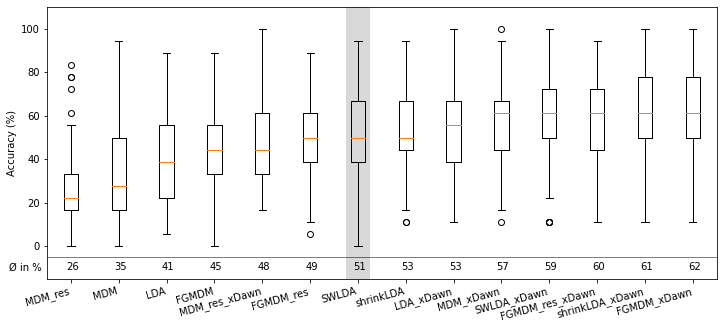

In [16]:
boxplot_accuracy(eight_epochs,r"All_conditions",r"all_conditions")

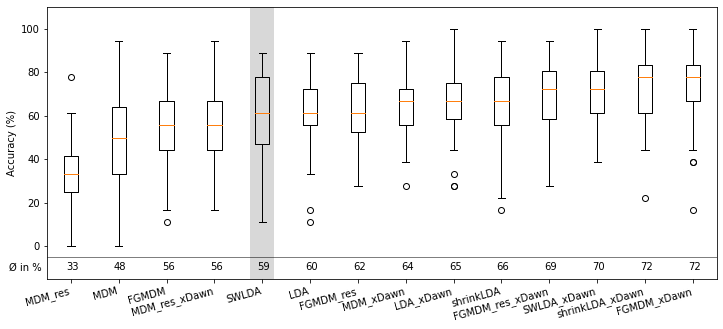

In [17]:
boxplot_accuracy(sess3,r"Sessionwise Calibration - 3 Runs",r"$\bf{Sessionwise}$ Calibration - $\bf{3}$ Runs")

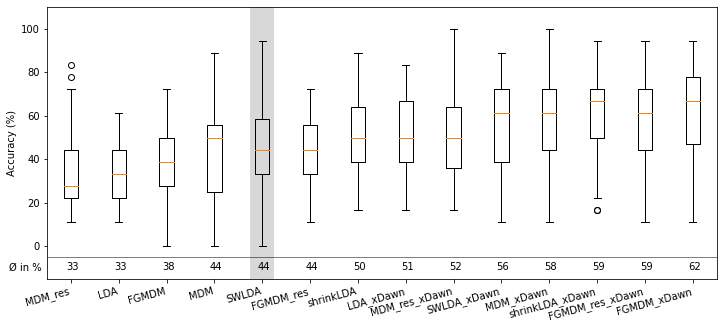

In [18]:
boxplot_accuracy(sess1,"Sessionwise Calibration - 1 Run",r"$\bf{Sessionwise}$ Calibration - $\bf{1}$ Run")

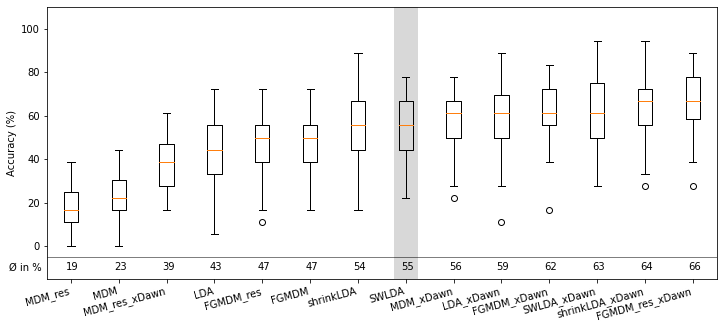

In [19]:
boxplot_accuracy(single3,r"Single Calibration - 3 Sessions (9 Runs)",r"$\bf{Single}$ Calibration - 3 Sessions ($\bf{9}$ Runs)")

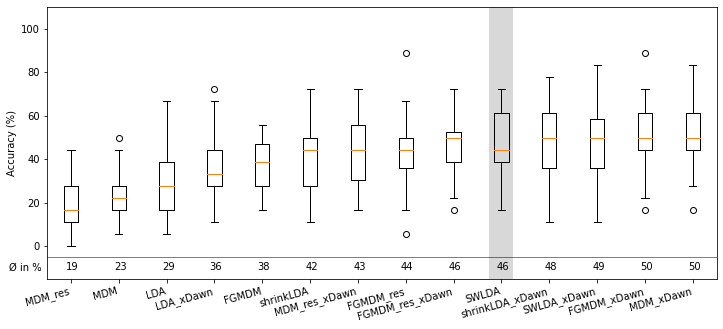

In [20]:
boxplot_accuracy(single1,r"Single Calibration - 1 Session (3 Runs)",r"$\bf{Single}$ Calibration - 1 Session ($\bf{3}$ Runs)")

In [43]:
sess3.groupby("Classifier").mean().sort_values("Accuracy")

,Accuracy,Session,Ep2Avg
Classifier,,,
MDM_res,0.326211,27.589744,8.0
MDM,0.481481,27.589744,8.0
FGMDM,0.555556,27.589744,8.0
MDM_res_xDawn,0.556980,27.589744,8.0
SWLDA,0.585470,27.589744,8.0
LDA,0.599715,27.589744,8.0
FGMDM_res,0.618234,27.589744,8.0
MDM_xDawn,0.642450,27.589744,8.0
LDA_xDawn,0.653846,27.589744,8.0


In [53]:
sess1.groupby("Classifier").max()

,Accuracy,Session,Condition,Ep2Avg
Classifier,,,,
FGMDM,0.722222,49,sess1,8
FGMDM_res,0.722222,49,sess1,8
FGMDM_res_xDawn,0.944444,49,sess1,8
FGMDM_xDawn,0.944444,49,sess1,8
LDA,0.611111,49,sess1,8
LDA_xDawn,0.833333,49,sess1,8
MDM,0.888889,49,sess1,8
MDM_res,0.833333,49,sess1,8
MDM_res_xDawn,1.000000,49,sess1,8


In [277]:
sess3["ITR"] = itr(sess3.Accuracy)

In [278]:
sess3

,Accuracy,Classifier,Session,Condition,Ep2Avg,ITR
7,0.611111,MDM_res_xDawn,1,sess3,8,1.447403e+00
15,0.555556,FGMDM_res_xDawn,1,sess3,8,1.132900e+00
23,0.277778,MDM_res_xDawn,2,sess3,8,1.121154e-01
31,0.333333,FGMDM_res_xDawn,2,sess3,8,2.393440e-01
39,0.166667,MDM_res_xDawn,3,sess3,8,-8.953411e-16
47,0.277778,FGMDM_res_xDawn,3,sess3,8,1.121154e-01
55,0.388889,MDM_res_xDawn,5,sess3,8,4.071123e-01
63,0.277778,FGMDM_res_xDawn,5,sess3,8,1.121154e-01
71,0.444444,MDM_res_xDawn,6,sess3,8,6.127548e-01
79,0.611111,FGMDM_res_xDawn,6,sess3,8,1.447403e+00


### Classifies: Best/Worst - Sessionwise Ranking

In [21]:
def Per2Ac_BW(x):
    return x*5

def Ac2Per_BW(x):
    return x/5




best_performance =pd.DataFrame(columns=["Classifier"])
worst_performance =pd.DataFrame(columns=["Classifier"])
for session in range(1,40):
    df = sess1.loc[(sess1.Ep2Avg==8) &(sess1.Session==session)]
    print(session)
    print(df.Accuracy.max())
    print(df.loc[df.Accuracy == df.Accuracy.max()]["Classifier"])
    print("___________________________________")
    best_performance = best_performance.append(df.loc[df.Accuracy == df.Accuracy.max()])
    worst_performance = worst_performance.append(df.loc[df.Accuracy == df.Accuracy.min()])
performance = pd.DataFrame()
performance["Accuracy"] = sess1.loc[(sess1.Ep2Avg==8)].groupby("Classifier").mean().sort_values("Accuracy")["Accuracy"]*20
performance["Worst"] =worst_performance.groupby("Classifier").count().Accuracy
performance["Best"] =best_performance.groupby("Classifier").count().Accuracy





1
0.6666666666666666
5655    FGMDM_xDawn
Name: Classifier, dtype: object
___________________________________
2
0.3888888888888889
5023          FGMDM_res
5663        SWLDA_xDawn
5679    shrinkLDA_xDawn
5695        FGMDM_xDawn
7223              SWLDA
7255              FGMDM
Name: Classifier, dtype: object
___________________________________
3
0.5555555555555556
5735    FGMDM_xDawn
Name: Classifier, dtype: object
___________________________________
4
nan
Series([], Name: Classifier, dtype: object)
___________________________________
5
0.3333333333333333
5055    FGMDM_res
Name: Classifier, dtype: object
___________________________________
6
0.5
5071    FGMDM_res
Name: Classifier, dtype: object
___________________________________
7
nan
Series([], Name: Classifier, dtype: object)
___________________________________
8
0.6111111111111112
5839    shrinkLDA_xDawn
Name: Classifier, dtype: object
___________________________________
9
0.3888888888888889
7447    MDM
Name: Classifier, dtype: object


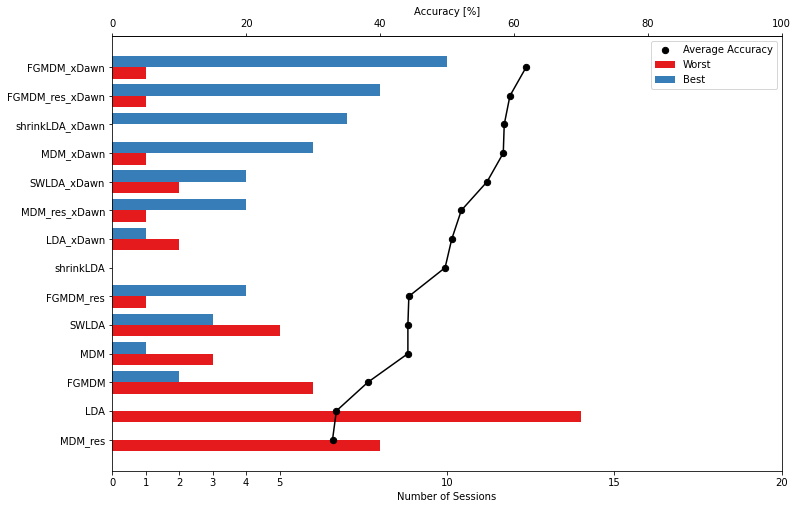

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
col_list= ["#377eb8","#e41a1c","k"]
#col_list= ["#d8b365","#5ab4ac","#ef8a62","#67a9cf"]
y= np.arange(len(performance.index))
height=0.8
ax.barh(y- (height/4),performance.Worst, label="Worst",height=height/2, color =col_list[1])
ax.barh(y+( height/4),performance.Best, label="Best",height=height/2,color =col_list[0])
ax.scatter(performance.Accuracy,performance.index, alpha=1,label="Average Accuracy", marker ="o",color =col_list[2], s=40,zorder=4)
ax.plot(performance.Accuracy,performance.index, alpha=1,color =col_list[2])
ax.set_xticks([0,1,2,3,4,5,10,15,20])
ax.set_xlabel("Number of Sessions")
sec_ax = ax.secondary_xaxis("top",functions= (Per2Ac_BW,Ac2Per_BW))
sec_ax.set_xlabel("Accuracy [%]")
ax.legend()
plt.savefig(r"created_data\Graphics\best_worst_sess1.svg",bbox_inches="tight",pad_inches=0.2,format="svg")

# ROC curves

In [83]:
all_roc = pd.read_csv(r"created_data\Classifier_Results\current\roc.csv")
all_roc["Condition"] = all_roc["Condition"].map({"sess3":"sess3","sess1":"sess1","single3_A":"single3","single3_B":"single3","single1_A":"single1","single1_B":"single1"}, na_action='ignore')
all_roc.to_csv(r"created_data\Classifier_Results\current\roc_rightlabel.csv",index=False)
all_roc["Condition"].isnull().any().sum()

0

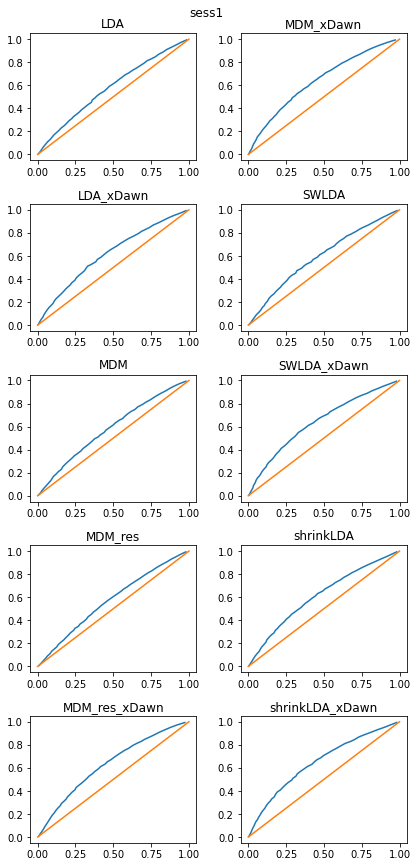

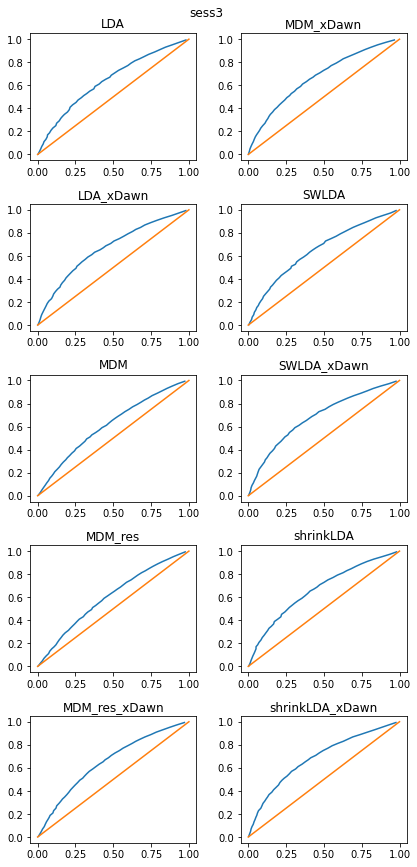

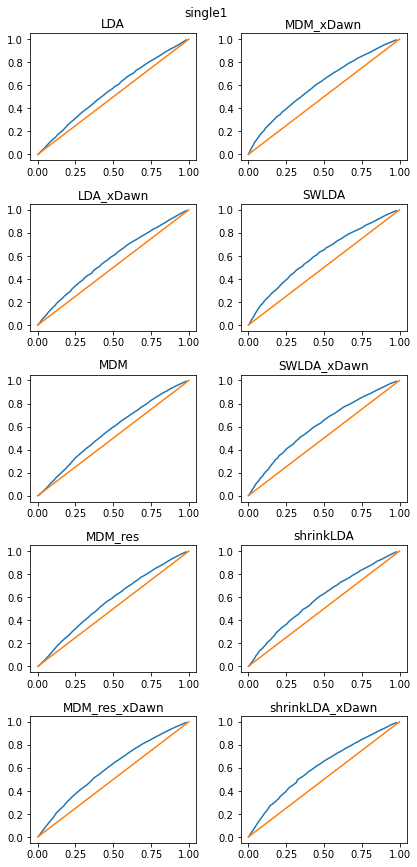

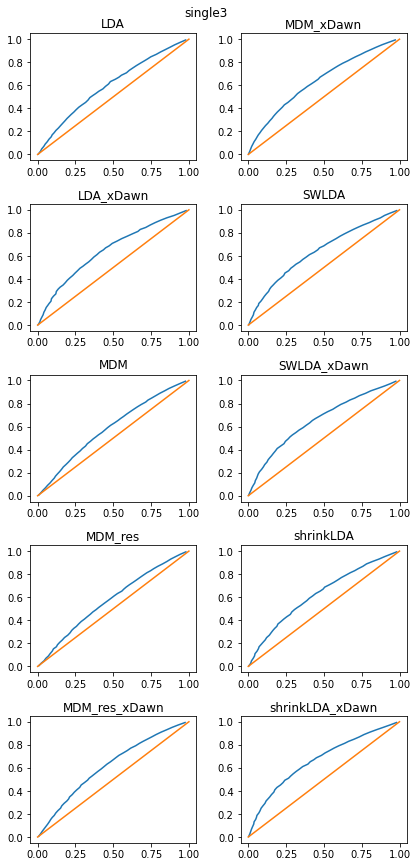

In [88]:
for condition in np.unique(all_roc.Condition):
    k=0       
    fig, ax = plt.subplots(5,2, figsize=(6,12))
    for i,classifier in enumerate(np.unique(all_roc.Classifier)):
        k = 1 if i>=5 else 0
        roc = all_roc.loc[(all_roc.Classifier==classifier) & (all_roc.Condition==condition)]
        roc["binnedTPR"] = pd.cut(roc.TPR,50)
        roc = roc.groupby("binnedTPR").mean().dropna()
        ax[i-(k*5)][k].plot(roc.FPR,roc.TPR)
        ax[i-(k*5)][k].plot([0,1],[0,1])        
        title = classifier
        ax[i-(k*5)][k].title.set_text(title)
    fig.tight_layout()
    fig.suptitle(condition, y=1)
    plt.savefig(r"created_data\Graphics\roc_"+condition+".svg",bbox_inches="tight",pad_inches=0.2,format="svg")

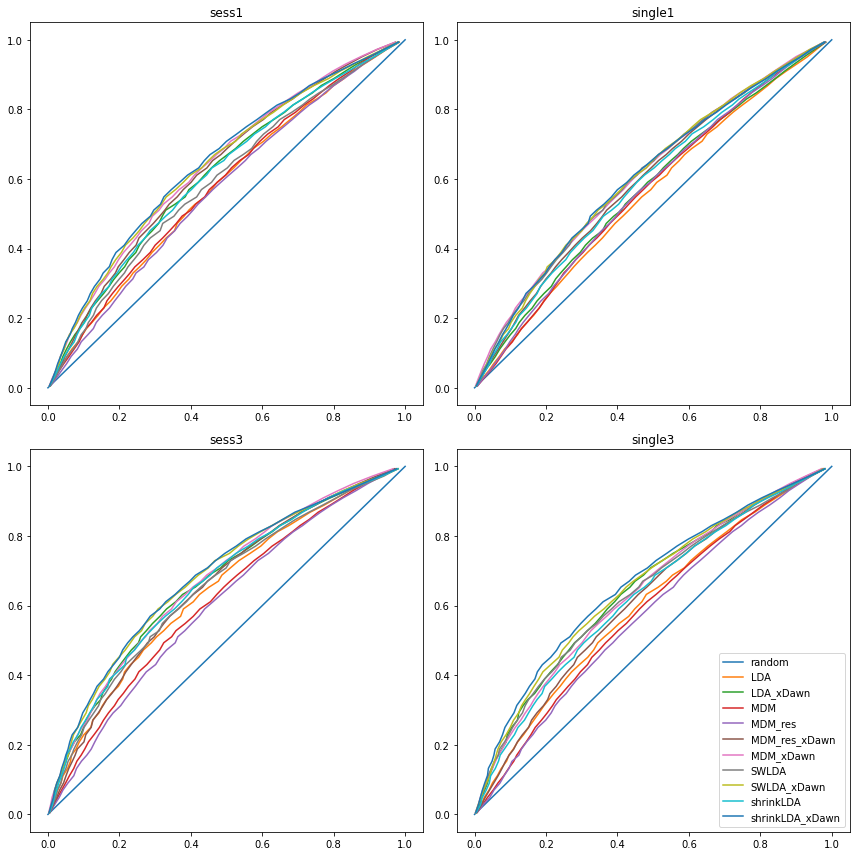

In [96]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
for i,condition in enumerate(np.unique(all_roc.Condition)):
    k = 1 if i>=2 else 0
    ax[i-(k*2)][k].plot([0,1],[0,1], label = "random") 
    for classifier in np.unique(all_roc.Classifier):
        roc = all_roc.loc[(all_roc.Classifier==classifier) & (all_roc.Condition==condition)]
        roc["binnedTPR"] = pd.cut(roc.TPR,50)
        roc = roc.groupby("binnedTPR").mean().dropna()
        ax[i-(k*2)][k].plot(roc.FPR,roc.TPR,label=classifier)
    ax[i-(k*2)][k].title.set_text(condition)
plt.legend()
fig.tight_layout()
plt.savefig(r"created_data\Graphics\roc.svg",bbox_inches="tight",pad_inches=0.2,format="svg")

In [59]:
np.unique(all_roc.Classifier)

array(['LDA', 'LDA_xDawn', 'MDM', 'MDM_res', 'MDM_res_xDawn', 'MDM_xDawn',
       'SWLDA', 'SWLDA_xDawn', 'shrinkLDA', 'shrinkLDA_xDawn'],
      dtype=object)

In [37]:
classifier = "MDM_res"
condition = "single3_B"

In [38]:
roc = all_roc.loc[(all_roc.Classifier==classifier) & (all_roc.Condition==condition)]
roc["Treshold_bin"] = pd.cut(roc.Treshold,50)
roc = roc.groupby("Treshold_bin").mean().dropna()

In [39]:
roc.describe()

,Session,Treshold,FPR,TPR
count,41.000000,41.000000,41.000000,41.000000
mean,36.295764,0.897311,0.186223,0.193947
std,4.589923,0.573880,0.175042,0.186635
min,22.000000,0.005527,0.000000,0.000000
25%,35.093041,0.415413,0.000000,0.000000
50%,36.818182,0.817555,0.225617,0.236170
75%,37.750000,1.373937,0.322601,0.329545
max,47.000000,1.995904,0.529167,0.559028


ZeroDivisionError: division by zero

In [51]:
roc = all_roc.loc[(all_roc.Classifier==classifier) & (all_roc.Condition==condition) & (all_roc.Session==33)]

Text(0.5, 1.0, 'MDM_ressingle3_B')

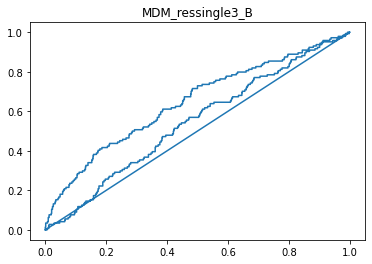

In [52]:
        fig, ax = plt.subplots()
        ax.plot(roc.FPR,roc.TPR)
        
        title = classifier + condition
        ax.set_title(title)

In [55]:
roc

,Classifier,Session,Condition,Treshold,FPR,TPR
308117,MDM_res,33,single3_B,1.448746,0.000000,0.000000
308118,MDM_res,33,single3_B,0.448746,0.001389,0.000000
308119,MDM_res,33,single3_B,0.132755,0.005556,0.000000
308120,MDM_res,33,single3_B,0.108588,0.005556,0.006944
308121,MDM_res,33,single3_B,0.079358,0.011111,0.006944
308122,MDM_res,33,single3_B,0.067241,0.011111,0.020833
308123,MDM_res,33,single3_B,0.065314,0.012500,0.020833
308124,MDM_res,33,single3_B,0.054306,0.012500,0.027778
308125,MDM_res,33,single3_B,0.031461,0.029167,0.027778
308126,MDM_res,33,single3_B,0.031279,0.029167,0.034722


In [3]:
pd.read_csv(r"G:\Meine Ablage\PhD\P300\LIS_Paper\DataAnalysis\h1.csv")

,Unnamed: 0,FGMDM,FGMDM_res,FGMDM_res_xDawn,FGMDM_xDawn,LDA,LDA_xDawn,MDM,MDM_res,MDM_res_xDawn,MDM_xDawn,shrinkLDA,shrinkLDA_xDawn,SWLDA
0,FGMDM_res,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FGMDM_res_xDawn,0.093,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FGMDM_xDawn,0.002,0.164,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LDA,1.000,1.000,1.000,0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LDA_xDawn,1.000,1.000,1.000,1.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MDM,1.000,0.531,0.003,0.000,0.905,0.038,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MDM_res,0.000,0.000,0.000,0.000,0.000,0.000,0.068,NaN,NaN,NaN,NaN,NaN,NaN
7,MDM_res_xDawn,1.000,1.000,0.077,0.002,1.000,1.000,1.000,0.0,NaN,NaN,NaN,NaN,NaN
8,MDM_xDawn,1.000,1.000,1.000,0.685,1.000,1.000,0.071,0.0,1.000,NaN,NaN,NaN,NaN
9,shrinkLDA,0.735,1.000,1.000,1.000,1.000,1.000,0.018,0.0,0.561,1.0,NaN,NaN,NaN


In [45]:
single3.groupby("Classifier").mean().sort_values("Accuracy",ascending=False).reset_index().sort_values("Classifier",key=lambda col: col.str.lower())

,Classifier,Accuracy,Session,Ep2Avg
9,FGMDM,0.384615,27.589744,8.0
6,FGMDM_res,0.443020,27.589744,8.0
5,FGMDM_res_xDawn,0.461538,27.589744,8.0
1,FGMDM_xDawn,0.501425,27.589744,8.0
11,LDA,0.287749,27.589744,8.0
10,LDA_xDawn,0.361823,27.589744,8.0
12,MDM,0.226496,27.589744,8.0
13,MDM_res,0.190883,27.589744,8.0
7,MDM_res_xDawn,0.433048,27.589744,8.0
0,MDM_xDawn,0.502849,27.589744,8.0


In [27]:
sess3.groupby("Classifier").std()

,Accuracy,Session,Ep2Avg
Classifier,,,
FGMDM,0.180246,14.458139,0.0
FGMDM_res,0.161307,14.458139,0.0
FGMDM_res_xDawn,0.174624,14.458139,0.0
FGMDM_xDawn,0.164946,14.458139,0.0
LDA,0.164301,14.458139,0.0
LDA_xDawn,0.162452,14.458139,0.0
MDM,0.226327,14.458139,0.0
MDM_res,0.160803,14.458139,0.0
MDM_res_xDawn,0.179110,14.458139,0.0
